### Домашнее задание
#### Копчев Владислав, 197

Вариант 12

Буду приводить код вместе с графиками (которые также генерируются кодом) и пояснениями, так как код показывает, как именно были проведены вычисления, какие были получены значения статистик при проведении статистических тестов, параметров при оценке параметров и т. д.

#### Начало работы

Импортируем библиотеки, необходимые для работы с временными рядами. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf 
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox

Посмотрим, как выглядит наш временной ряд:

In [2]:
data = [29.0000,41.0000,45.9086,82.9764,50.1842,162.8469,191.8593,111.0904,99.0750,224.3616,116.2578,116.9491,275.1313,117.6952,228.4903,141.2557,188.2157,163.5705,341.6737,119.8401,248.1362,167.4857,394.8298,279.3860,509.0672,271.1141,340.5113,344.5897,377.3939,300.8403,472.7250,296.9327,472.6368,399.2436,432.3218,455.5685,394.8581,406.6288,429.9800,487.9591,479.1992,495.8078,580.9684,560.7369,588.8370,559.5699,615.6154,386.6111,701.0147,639.2583,745.1451,580.9272,683.1867,610.7892,705.4340,615.6806,758.8160,548.1212,855.9842,747.3182,730.5456,610.3668,871.4836,689.3169,766.2238,619.5603,836.9217,718.3707,825.2047,884.2796,725.1384,954.2957,943.5638,873.9041,1102.2948,817.3666,1084.9598,914.1155,1074.5009,958.1321,1124.3717,872.8296,1036.6171,856.8074,1125.1867,946.2893,1104.3035,959.0090,1155.7775,1158.1286,931.0661,1109.0423,1238.3436,1217.2781,1047.9036,1395.8866,974.0951,1356.9469,1166.8223,1217.7237,1193.3087,1237.0121,1272.3487,1315.8510,1266.2457,1454.4778,1301.1012,1295.1743,1365.5671,1329.6998,1293.4068,1347.9442,1477.2883,1384.3932,1534.6250,1389.4182,1345.6936,1441.9758,1297.8820,1554.3925,1446.5397,1507.4276,1337.9362,1531.8693,1691.7953,1420.5599,1657.8376,1714.6095,1472.5759,1620.0205,1492.9250,1560.0822,1727.8511,1548.7546,1728.1283,1494.3665,1691.3756,1619.5240,1771.1205,1608.9244,1751.6363,1805.2195,1575.2795,1822.2113,1686.9070,1723.3278,1816.6533,1799.4598,1822.2530,1870.3998,1881.1847,1821.7198,1929.0190,1769.7292,2013.1381,1677.5822,2002.2911,1706.2916,2058.4791,1777.2912,2016.6429,2046.2236,1892.6964,1931.0038,2058.6323,2087.5352,1885.9200,2142.9258,2093.8599,2060.5928,2068.9355,2155.5485,2197.4866,2204.1770,1950.5981,2378.2923,2093.1648,2178.2834,2154.4675,2400.4288,2005.7132,2314.5268,2072.5643,2315.1349,2170.6152,2341.1479,2212.9867,2233.4355,2297.7539,2171.1379,2246.8705,2367.8873,2355.5305,2286.0411,2334.0236,2330.0015,2405.4280,2503.3349,2383.5818,2521.8297]

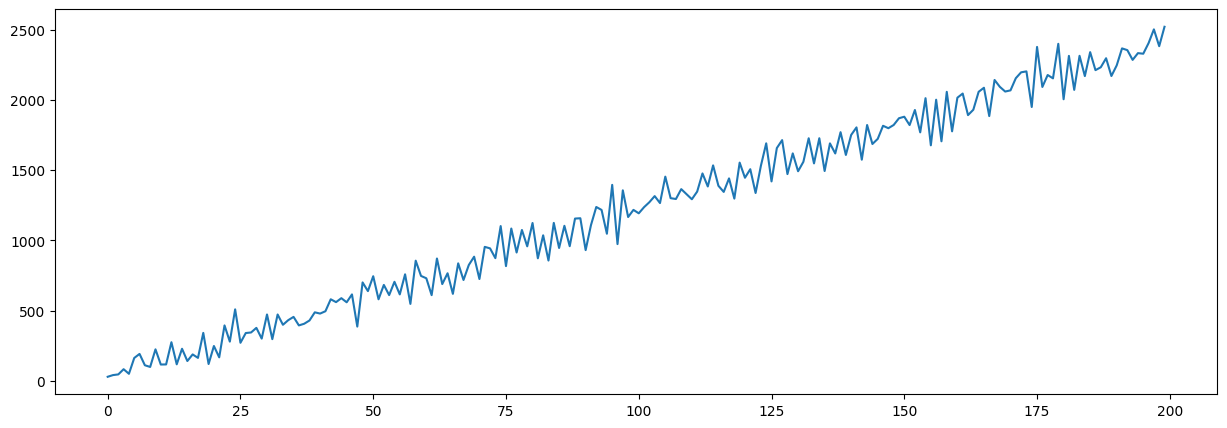

In [3]:
plt.figure(figsize=(15,5)) 
plt.plot(data)
plt.show()

#### Относится ои ряд к типу TSP?

Выясним, относится ли наш ряд к типу TSP. TSP описывается формулой $X_t = \theta_0 + \theta_1 t + u_t, u_t = AR(p)$. Сделаем это с помощью процедуры Доладо-Дженкинса-Сосвилла-Риверо. Для начала рассмотрим модель наиболее общего вида порядка $p$: $X_t = \mu + bt + \alpha_1 X_{t-1} + \alpha_2 X_{t-2} + \ldots + \alpha_p X_{t-p} + \varepsilon_t,$ $\varepsilon_t \sim WN(0, \sigma^2)$. Первый шаг: проведем ADF-тест. Нулевая гипотеза: у ряда есть единичный корень (значит, он описывается моделью DSP), альтернативная гипотеза: у ряда нет единичного корня (значит, выбираем модель TSP). Для этого теста как раз есть функция в библиотеке `statsmodels`.

In [4]:
res = adfuller(data, regression='ct')
print('ADF Statistic: %f' % res[0]) 
print('p-value: %f' % res[1]) 
print('Critical Values:')
for key, value in res[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -24.637493
p-value: 0.000000
Critical Values:
	1%: -4.005
	5%: -3.433
	10%: -3.140


Мы видим: $p$-value практически равен нулю, значение статистики существенно меньше критического значения. Поэтому мы можем с уверенностью отклонять нулевую гипотезу. Получается, наш ряд относится к TSP.

#### Оценим детерминированную составляющую ряда

Мы поняли, что наш ряд относится к TSP. Оценим параметры $\mu$ и $b$ с помощью МНК. Для этого тоже как раз есть функция в библиотеке `statsmodels`.

In [5]:
ar_model = AutoReg(data, trend='ct', lags=0).fit()
mu = ar_model.params[0]
b = ar_model.params[1]
print('Constant value: %f' % mu)
print('Trend value: %f' % b)

Constant value: 9.338441
Trend value: 12.081341


Посмотрим одновременно на график всего ряда и его детерминированной составляющей. Мы видим, что прямая действительно задает "направление", в котором движется ряд с какими-то случайнвми колебаниями.

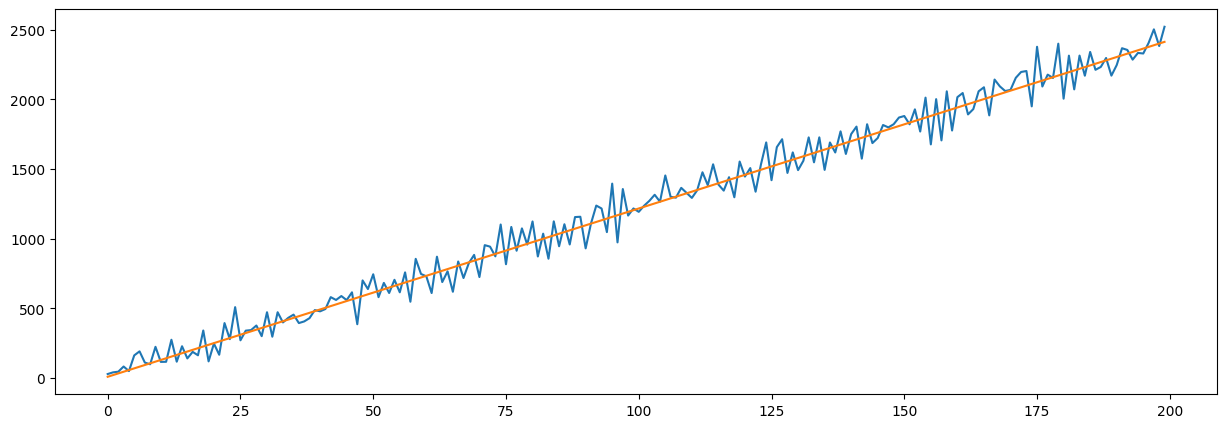

In [6]:
trend = mu + b * np.arange(0, 200) # здесь np.arange(0, 200) задает значения t = [0, 200), то есть нумерацию ряда считаем с нуля
plt.figure(figsize=(15,5)) 
plt.plot(data) 
plt.plot(trend)
plt.show()

#### Детрендируем ряд

Вычтем из временного ряда прямую $\mu + bt$, чтобы оставить только те самые "случайные колебания" вокруг этой прямой — таким образом, мы детрендируем ряд, оставляя только его случайную составляющую.

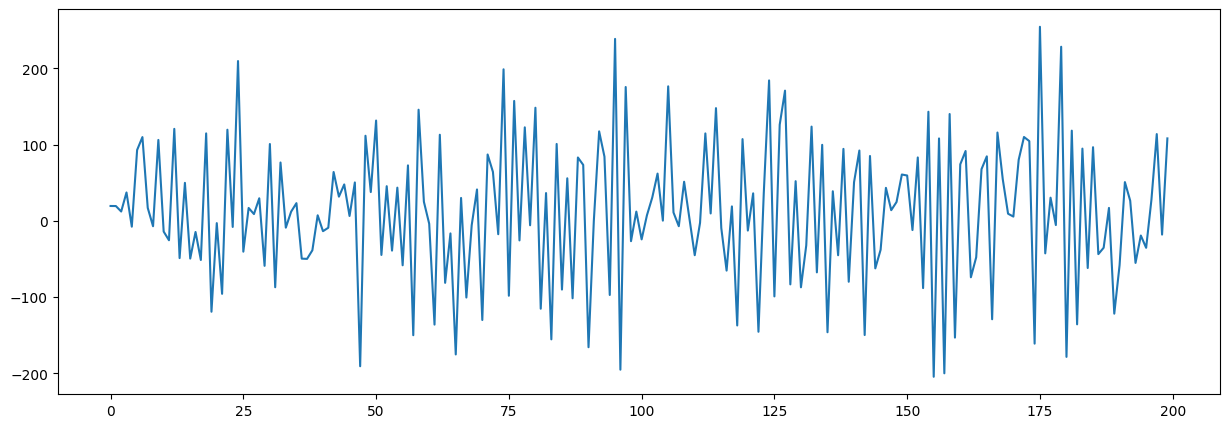

In [7]:
data_detrend = data - trend
plt.figure(figsize=(15,5)) 
plt.plot(data_detrend) 
plt.show()

Проведем визуальный анализ этого графика. Мы видим, что ряд на этом графике похож на стационарный, матожидание примерно равно 0, тренд на графике не виден.

#### Идентифицируем случайную составляющую

Построим ACF и PACF случайной составляющей нашего ряда с помощью функций `plot_acf` и `plot_pacf` из все той же библиотеки:

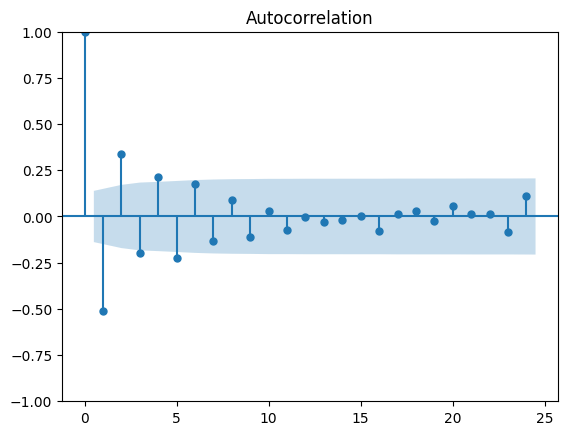

In [8]:
plot_acf(data_detrend)
plt.show()

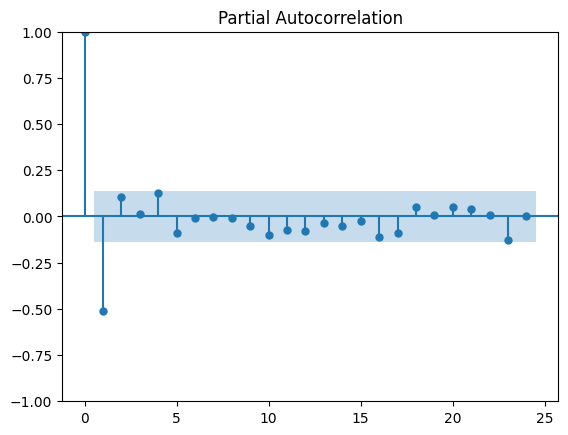

In [9]:
plot_pacf(data_detrend, method='ywm')
plt.show()

Благодаря этим графикам, как мы это уже делали на статистической игре, можно понять, какая модель описывает случайную составляющую нашего ряда. Проанализируем ACF. Мы видим, что значения у 1 и 2 сильно выскакивают из трубки, а дальше они уже находятся в границах интервала. Получается, мы можем предположить, что наша случайная составляющая описывается моделью MA(1) или MA(2). Посмотрим теперь на график PACF. Мы видим, что у 1 значение сильно выбивается из трубки, а дальше все значения находятся в ее границах. Поэтому можем предположить, что случайная составляющая описывается моделью AR(1). Поскольку выбирать нужно всегда более простую модель, из MA(1) и MA(2) стоило бы выбрать именно MA(1), однако мы проверим все 3 модели.

#### Оценим параметры выбранных моделей

Чтобы оценить параметры выбранных моделей, воспользуемся соответствующими функциями из библиотеки `statsmodels`.

In [10]:
ma1 = ARIMA(data_detrend, order=(0, 0, 1), trend='n')
ma2 = ARIMA(data_detrend, order=(0, 0, 2), trend='n')
ar1 = ARIMA(data_detrend, order=(1, 0, 0), trend='n')

Запустим функции для оценки параметров:

In [11]:
ma1_model = ma1.fit()
ma2_model = ma2.fit()
ar1_model = ar1.fit()

Итак, мы оценили параметры. Посмотрим на них в разделе `coef` в таблице. 

In [12]:
ma1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1173.251
Date:                Wed, 22 Mar 2023   AIC                           2350.501
Time:                        23:04:26   BIC                           2357.098
Sample:                             0   HQIC                          2353.171
                                - 200                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3432      0.076     -4.510      0.000      -0.492      -0.194
sigma2      7288.1245    739.987      9.849      0.000    5837.777    8738.472
===================================================================================
Ljung-Box (L1) (Q):                   5.73   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.02   Prob(JB):                         1.00
Heteroskedasticity (H):               1.41   Skew:                             0.01
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Итог:** Мы видим, что у MA(1) параметры -0.3432 и 7288.1245

In [14]:
ma2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -1162.619
Date:                Wed, 22 Mar 2023   AIC                           2331.237
Time:                        23:04:34   BIC                           2341.132
Sample:                             0   HQIC                          2335.242
                                - 200                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4351      0.072     -6.022      0.000      -0.577      -0.293
ma.L2          0.3102      0.063      4.893      0.000       0.186       0.435
sigma2      6546.6582    671.850      9.744      0.000    5229.856    7863.460
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                 0.15
Prob(Q):                              0.50   Prob(JB):                         0.93
Heteroskedasticity (H):               1.23   Skew:                             0.03
Prob(H) (two-sided):                  0.39   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Итог:** Мы видим, что у MA(2) параметры -0.4351, 0.3102 и 6546.6582.

In [15]:
ar1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1163.987
Date:                Wed, 22 Mar 2023   AIC                           2331.974
Time:                        23:04:42   BIC                           2338.571
Sample:                             0   HQIC                          2334.644
                                - 200                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4882      0.068     -7.221      0.000      -0.621      -0.356
sigma2      6638.3164    656.611     10.110      0.000    5351.382    7925.251
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.50
Prob(Q):                              0.74   Prob(JB):                         0.78
Heteroskedasticity (H):               1.27   Skew:                             0.12
Prob(H) (two-sided):                  0.32   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Итог:** Мы видим, что у AR(1) параметры -0.4882 и 6638.3164

Построим графики, чтобы визуально определить, насколько хорошо эти модели описывают наши данные:

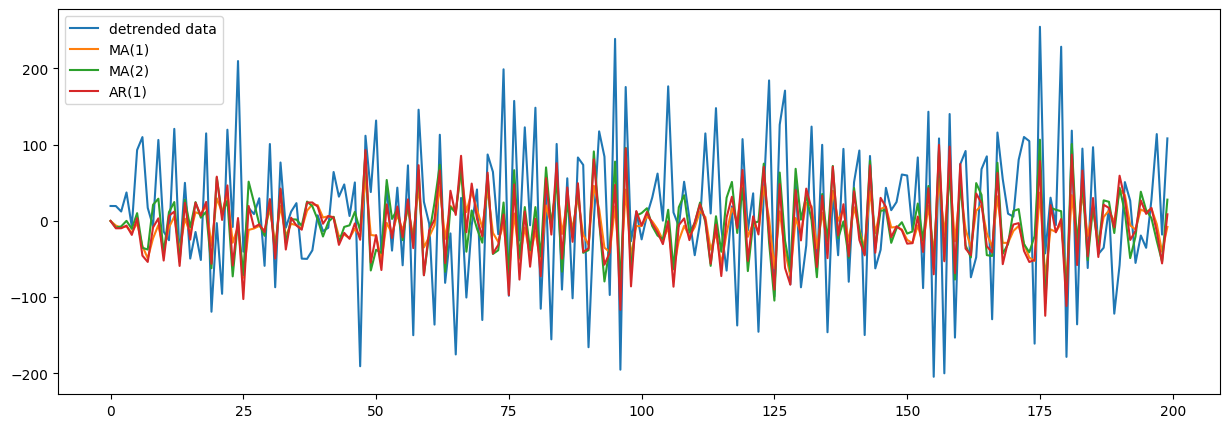

In [16]:
plt.figure(figsize=(15,5)) 
plt.plot(data_detrend) 
plt.plot(ma1_model.fittedvalues)
plt.plot(ma2_model.fittedvalues)
plt.plot(ar1_model.fittedvalues)
plt.legend(['detrended data', 'MA(1)', 'MA(2)', 'AR(1)'])
plt.show()

По графику видно, что MA(1) и MA(2) очень похожи между собой (еще один аргумент в пользу MA(1) вместо MA(2)), при этом все 3 модели выглядят похоже на наши данные. 

#### Выбор модели с помощью информационного критерия

Выше мы выводили подробную таблицу, в которой были, помимо всего прочего, указаны коэффициенты наших моделей. Однако в этой же таблице уже были посчитаны информационные критерии. Сведем их в единую таблицу:

In [17]:
inf_criteria = pd.DataFrame({
    'MA(1)': (2350.501, 2357.098),
    'MA(2)': (2331.237, 2341.132),
    'AR(1)': (2331.974, 2338.571)
}, index=['AIC', 'BIC'])

In [18]:
inf_criteria

,MA(1),MA(2),AR(1)
AIC,2350.501,2331.237,2331.974
BIC,2357.098,2341.132,2338.571


Теперь найдем минимум по `AIC` и `BIC`. Мы видим, что `AIC` меньше всего у MA(2) и практически такой же (совсем немного выше) у AR(1). `BIC` же самый маленький у AR(1). В результате видим, что AR(1) описывает данные незначительно хуже, чем MA(2) по `AIC` и лучше, чем MA(2), по `BIC`. Поэтому выбираем модель AR(1).

#### Проведем диагностику остатков

Теперь вычислим остатки как разность между детрендированным рядом и нашей моделью AR(1), у которой мы только что оценили параметры: $X_t - (\mu + bt) - \hat{y}_t$, где $\hat{y}_t$ — значение в момент $t$ модели AR(1) с найденными ранее параметрами. Построим график остатков:

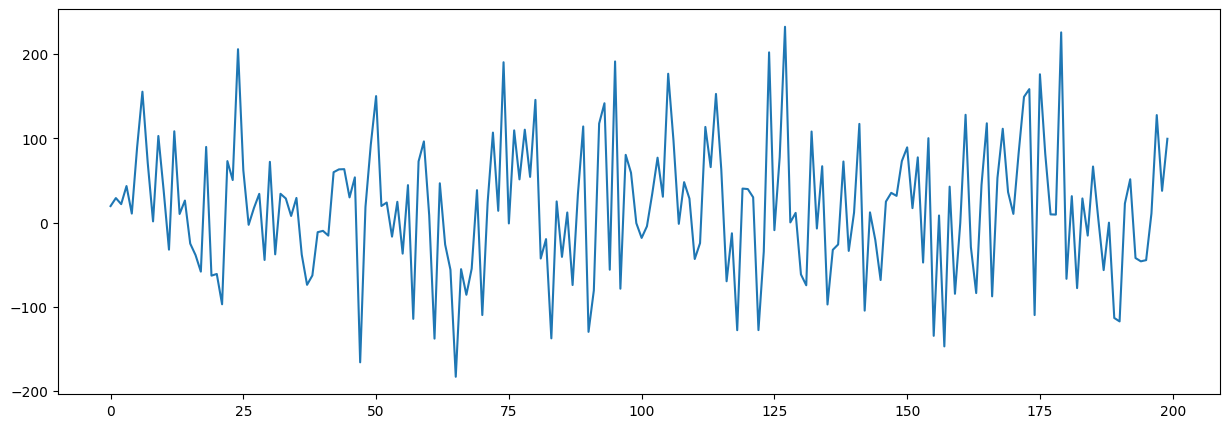

In [19]:
resid = data_detrend - ar1_model.fittedvalues
plt.figure(figsize=(15,5)) 
plt.plot(resid) 
plt.show()

Построим график ACF и PACF:

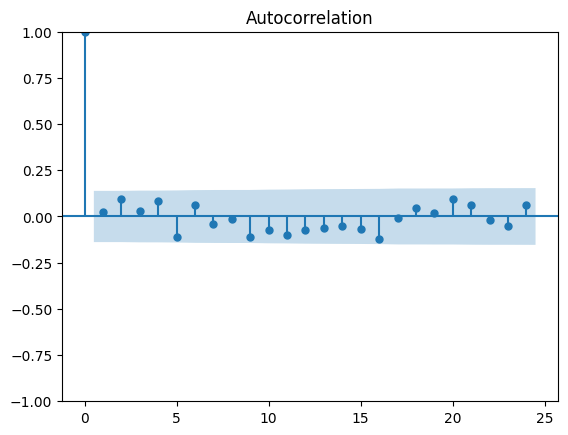

In [20]:
plot_acf(resid)
plt.show()

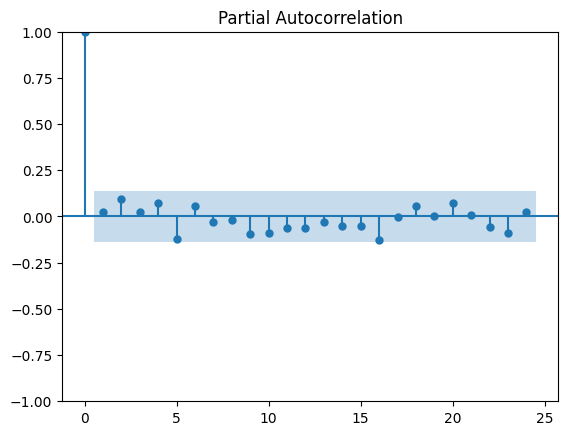

In [21]:
plot_pacf(resid, method='ywm')
plt.show()

По графикам видно, что это белый шум — у всего, что больше 0, значения попадают в трубку. Однако не будем ограничиваться лишь графическим анализом и проверим наше предположение о том, что это белый шум, еще и тестом Бокса–Пирса:

In [22]:
acf_ = acf(resid)
acorr_ljungbox(acf_, lags=[acf_.shape[0] - 1], boxpierce=True, model_df=2)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
23,10.306514,0.974651,3.435945,0.999995


Если мы считаем, что уровень значимости $\alpha = 0.05$ или какое-то подобное разумное значение, то $p$-value все равно не будет меньше, чем $\alpha$. Следовательно, принимаем нулевую гипотезу $H_0$ – остатки являются белым шумом.

#### Построим прогноз модели

Нам даны значения $X_1, \ldots, X_{200}$. Спрогнозируем $X_{201}$. Для этого с помощью всего, что мы сделали ранее в работе, построим оценку $\hat{X}_{201}$ для $X_{201}$: $\hat{X}_{201} = \mu + b \cdot 201 + \hat{y}_{201}$, где $\hat{y}_{201}$ — это модель AR(1) с нашими параметрами и $t = 201$.

In [63]:
x_201 = mu + b * 201 + ar1_model.forecast(steps=1)[0]
print("X_201 = ", x_201)

X_201 =  2384.811960984694


**Ответ:** 2384.812.